# Imports

In [1]:
import pathlib

import numpy as np
import pandas as pd
from glob import glob

from obspy.geodetics import gps2dist_azimuth

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.offsetbox import AnchoredText


import seaborn as sns

In [2]:
plt.style.use("../../qm_manuscript.mplstyle")
plt.rcParams.update({"font.family": "Helvetica"})

# Read in matched catalogues

In [3]:
man_qm_combined = pd.read_csv("./generate_results/outputs/QM-man_combined.csv")
man_qm_combined

,EventID,DT_QM,X_QM,Y_QM,Z_QM,COA,COA_NORM,GAU_X,GAU_Y,GAU_Z,...,Err_Y,Err_Z,Err_XYZ,FNAME,OBSFILE,epi_diff,epi_diff_az,X_diff,Y_diff,Z_diff
0,20070706220710720,2007-07-06 22:07:10.400,-16.410733,65.108052,0.2,16.880,15.740,-16.378624,65.108941,2.518,...,0.241529,0.429674,0.302224,loc.qm-man_matched.20070706.220711.grid0.loc.hyp,20070706220710720.nonlinloc,0.129784,240.286140,-0.112719,-0.064330,0.564648
1,20070708093230280,2007-07-08 09:32:30.160,-16.387421,65.095463,2.5,44.180,44.170,-16.368039,65.093149,3.563,...,0.287999,0.489068,0.343148,loc.qm-man_matched.20070708.093231.grid0.loc.hyp,20070708093230280.nonlinloc,0.226610,71.584594,0.215005,0.071587,0.500977
2,20070710071425880,2007-07-10 07:14:25.780,-16.670147,65.014875,2.4,9.049,9.251,-16.666983,65.013125,3.548,...,0.675917,1.137890,0.698632,loc.qm-man_matched.20070710.071427.grid0.loc.hyp,20070710071425880.nonlinloc,0.207924,316.333864,-0.143562,0.150407,0.019922
3,20070711152648140,2007-07-11 15:26:48.020,-16.836046,65.067624,5.0,5.297,5.457,-16.803586,65.075712,4.703,...,0.522033,0.862992,0.567283,loc.qm-man_matched.20070711.152649.grid0.loc.hyp,20070711152648140.nonlinloc,0.838369,96.421235,0.833110,-0.093761,-2.028320
4,20070711190211380,2007-07-11 19:02:11.300,-16.836039,65.066727,5.0,5.616,5.801,-16.804232,65.067250,4.620,...,0.485474,1.687971,0.811671,loc.qm-man_matched.20070711.190212.grid0.loc.hyp,20070711190211380.nonlinloc,1.123398,95.622168,1.117994,-0.110057,-2.423828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,20150604094117600,2015-06-04 09:41:17.500,-16.259690,65.102403,5.4,10.500,10.680,-16.266871,65.101224,5.544,...,0.341923,0.769946,0.514507,loc.qm-man_matched.20150604.094119.grid0.loc.hyp,20150604094117600.nonlinloc,0.138335,325.295444,-0.078760,0.113725,0.301172
1702,20150619173307500,2015-06-19 17:33:07.300,-16.202666,65.073561,5.4,19.240,18.590,-16.215300,65.073683,5.707,...,0.393298,0.916722,0.549043,loc.qm-man_matched.20150619.173309.grid0.loc.hyp,20150619173307500.nonlinloc,0.234056,270.329774,-0.234053,0.001347,0.047266
1703,20150621062432960,2015-06-21 06:24:32.780,-16.202653,65.074458,5.3,25.480,24.200,-16.213251,65.073954,5.529,...,0.403874,0.931397,0.569113,loc.qm-man_matched.20150621.062434.grid0.loc.hyp,20150621062432960.nonlinloc,0.327075,257.141566,-0.318873,-0.072788,0.225391
1704,20150621082710320,2015-06-21 08:27:10.140,-16.202653,65.074458,5.2,27.090,25.370,-16.212355,65.073629,5.792,...,0.397995,1.066783,0.629743,loc.qm-man_matched.20150621.082712.grid0.loc.hyp,20150621082710320.nonlinloc,0.316693,254.316123,-0.304902,-0.085612,0.540234


# Functions

In [4]:
def get_aspect(xmin, xmax, ymin, ymax, zmin, zmax, scale=1000):
    """
    Get aspect ratios for map, lat XS & lon XS for given coords.
    
    Assumes cross-section depths are in KILOMETRES.
    
    """
    
    map_ns_metres, _, _ = gps2dist_azimuth(ymin, xmin, ymax, xmin)
    map_ns_deg = ymax - ymin
    map_ew_metres, _, _ = gps2dist_azimuth(ymin, xmin, ymin, xmax)
    map_ew_deg = xmax - xmin
    
    map_aspect = (map_ns_metres / map_ns_deg) / (map_ew_metres / map_ew_deg)
    
    lat_aspect = (map_ns_metres / scale) / map_ns_deg
    lon_aspect = map_ew_deg / (map_ew_metres / scale)
    
    lon_xs_height_ratio = [(ymax - ymin), (zmax - zmin) / lat_aspect]
    lat_xs_width_ratio = [(xmax - xmin), (zmax - zmin) * lon_aspect]
    
    map_lon_fig_ratio = sum(lon_xs_height_ratio) * map_aspect / (xmax - xmin)
    
    map_lat_fig_ratio = (ymax - ymin) / sum(lat_xs_width_ratio) * map_aspect
    
    
    return (map_aspect, lat_aspect, lon_aspect, lat_xs_width_ratio, lon_xs_height_ratio,
            map_lon_fig_ratio, map_lat_fig_ratio)


def get_scalebar_deg(dist, xmin, xmax, ymin, ymax):
    """Get length of scalebar for given x-axis scaling."""
    
    y_mean = np.mean([ymin, ymax])
    
    map_ew_metres, _, _ = gps2dist_azimuth(y_mean, xmin, y_mean, xmax)
    map_ew_deg = xmax - xmin

    deg = dist * 1000 / (map_ew_metres / map_ew_deg)
    
    return deg

# XY files

In [5]:
# Cross-section topography
topo_bedrock_ew = pd.read_csv("./XY_FILES/topo_section_lon_dyngja.xygt",
                              sep="\s+", comment="#",
                              names=["X", "Y", "d", "Z"])

# Askja calderas
askja_calderas = []
for f in sorted(glob("./XY_FILES/askjacalderas_*.csv")):
    askja_calderas.append(pd.read_csv(f, comment="#",
                                      names=["X", "Y"]))

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1253788/3284316051.py:3: SyntaxWarning: invalid escape sequence '\s'
  sep="\s+", comment="#",


# Plot Figure 11

<>:135: SyntaxWarning: invalid escape sequence '\d'
<>:172: SyntaxWarning: invalid escape sequence '\d'
<>:135: SyntaxWarning: invalid escape sequence '\d'
<>:172: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1253788/1614099539.py:135: SyntaxWarning: invalid escape sequence '\d'
  ax_map.set_ylabel("Latitude / $\degree$N")
/tmp/ipykernel_1253788/1614099539.py:172: SyntaxWarning: invalid escape sequence '\d'
  ax_xs.set_xlabel("Longitude / $\degree$E")


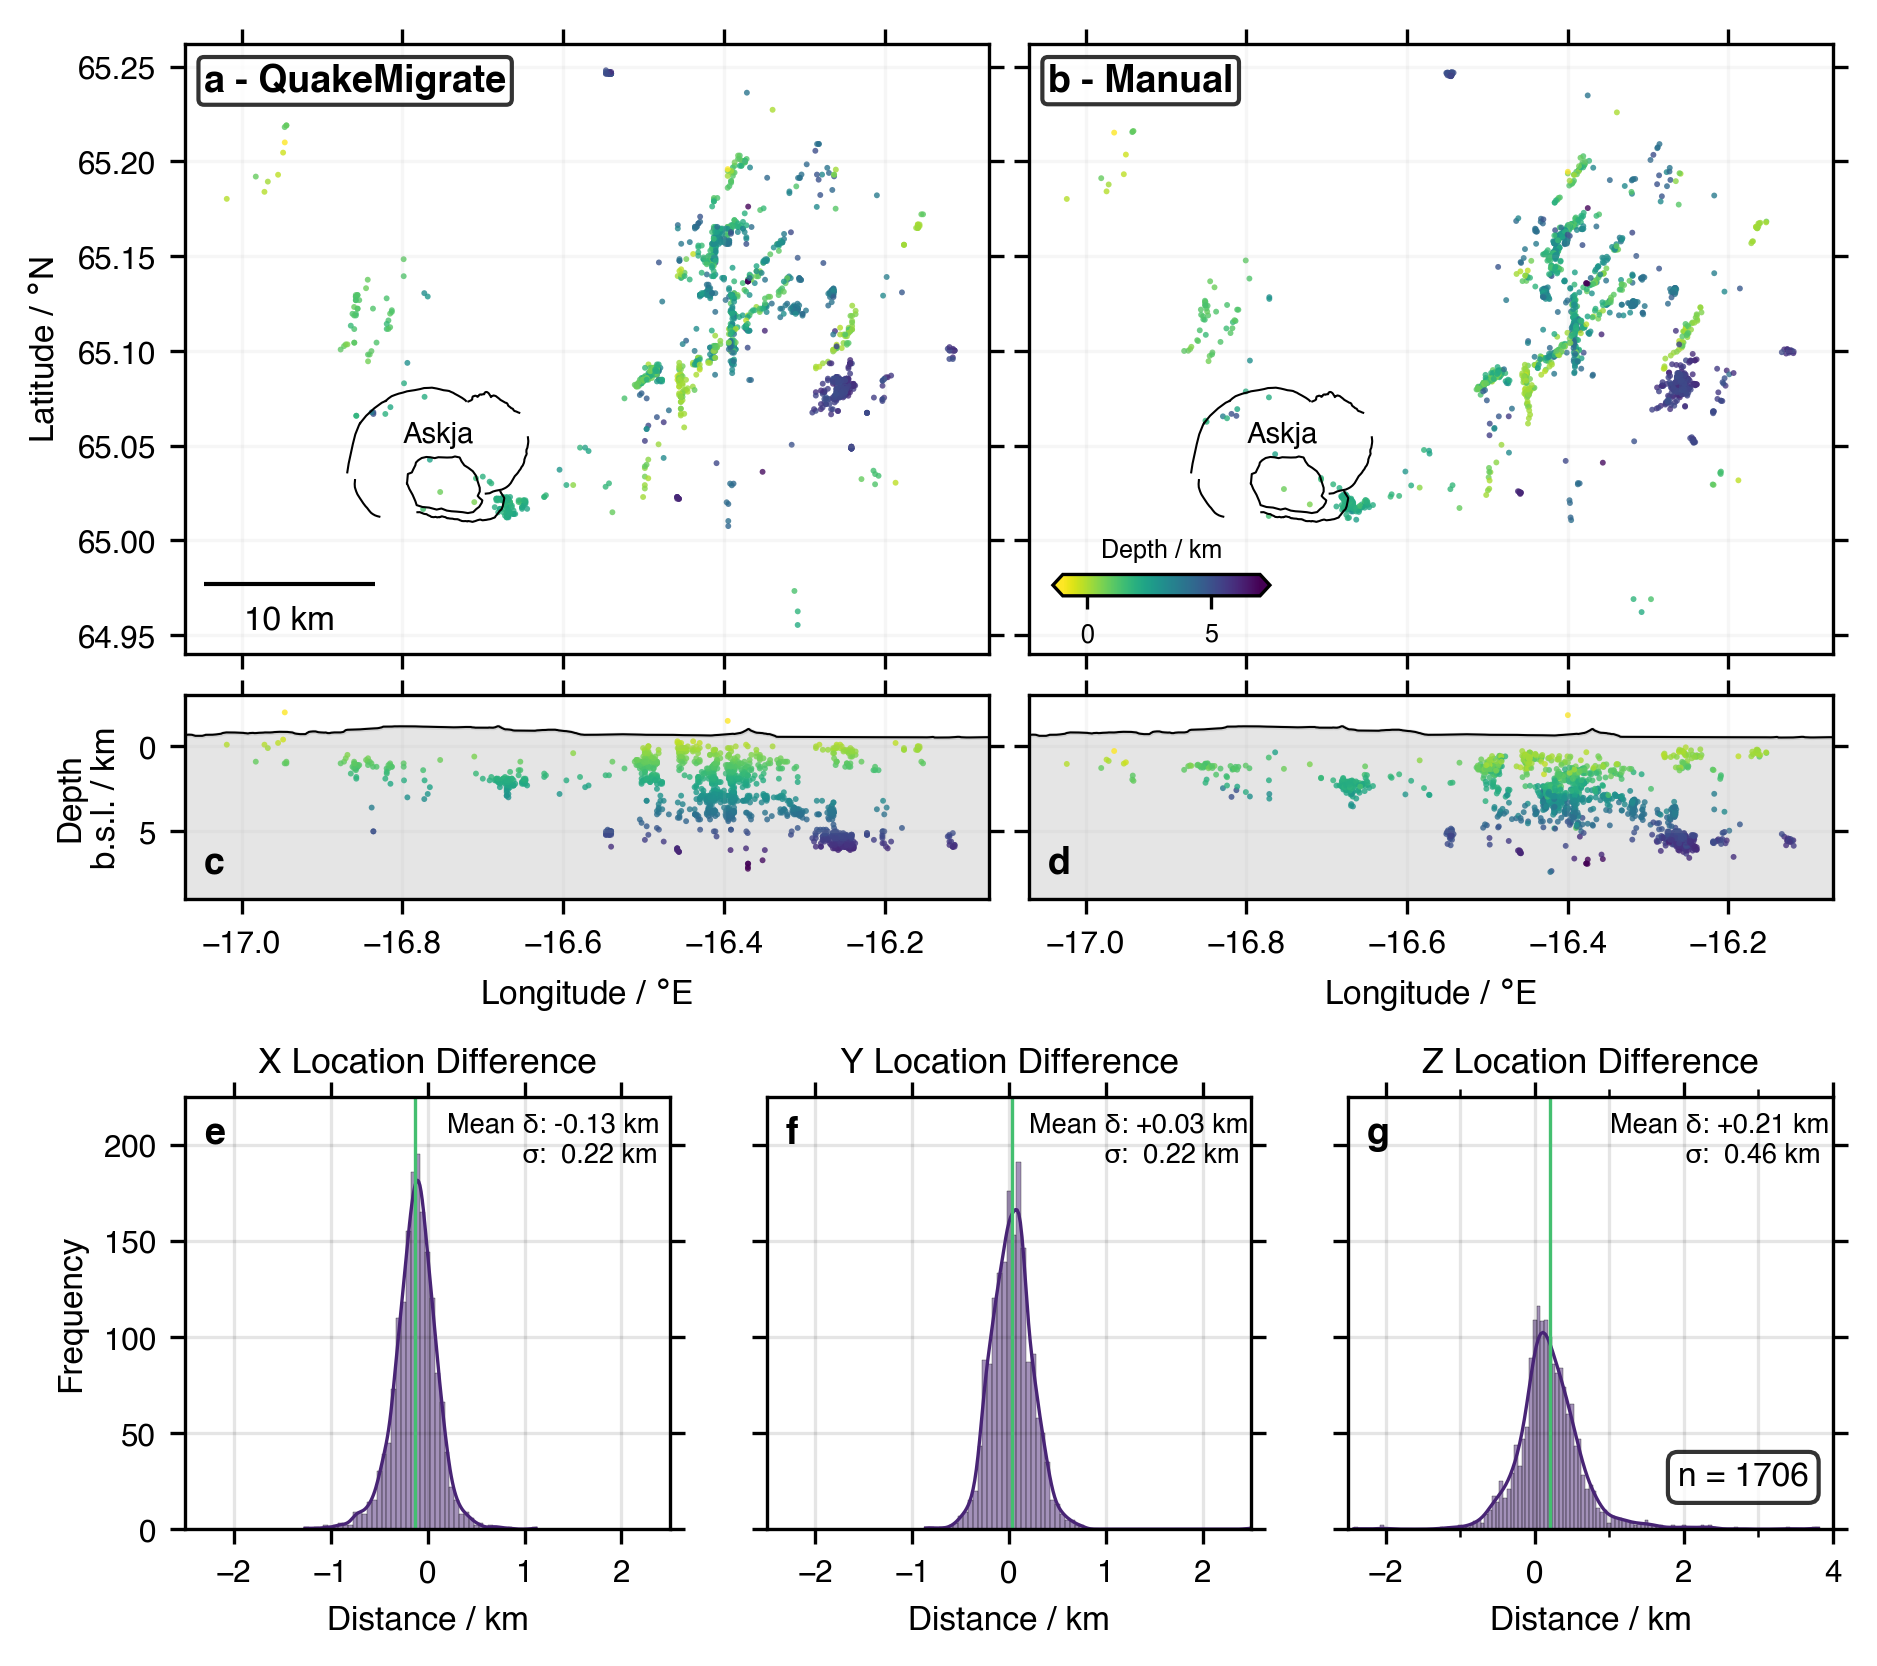

In [6]:
## Prep
plt.rcParams.update({
    'font.size': 8,
    'xtick.labelsize': 7.5,
    'ytick.labelsize': 7.5,
    'legend.fontsize': 7.5,
    'axes.labelsize': 8,
    'axes.titlesize': 7,
    'date.autoformatter.hour': '%H:%M'
})

# Make copy of input data
df = man_qm_combined.copy().sort_values(by="DT_QM").reset_index(drop=True)

# Set plot extent
xmin = -17.07 
xmax = -16.07
ymin = 64.94
ymax = 65.262
zmin = -3
zmax = 9

# Get aspect ratios
map_aspect, lat_aspect, lon_aspect, lat_xs_width_ratio, lon_xs_height_ratio, \
    map_lon_fig_ratio, map_lat_fig_ratio = get_aspect(xmin, xmax, ymin, ymax, zmin, zmax)

# Set height ratio for location difference axes
loc_diff_height = 0.25

# Setup figure
fig_width = 180 / 25.4  # Seismica full-width = 180; half-width = 86 mm
fig_height = map_lon_fig_ratio * fig_width * (0.5 + loc_diff_height + 0.15)

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300, facecolor="w")

# GridSpec
gs = GridSpec(nrows=2, ncols=1,
              height_ratios=[0.5, loc_diff_height],
              hspace=0.3)

# gridspec -- map & cross-sections subplot (top part of figure)
# do first as just 2 columns covering the relevant row, then split into
# map and xs row individually for each.
map_xs_gs = GridSpecFromSubplotSpec(nrows=1, ncols=2,
                                    width_ratios=[1, 1],
                                    subplot_spec=gs[0, :], wspace=0.05)
# LHS map & xs
map_xs_gs_1 = GridSpecFromSubplotSpec(nrows=2, ncols=1,
                                      height_ratios=lon_xs_height_ratio,
                                      subplot_spec=map_xs_gs[:, 0], hspace=0.1)
# RHS map & xs
map_xs_gs_2 = GridSpecFromSubplotSpec(nrows=2, ncols=1,
                                      height_ratios=lon_xs_height_ratio,
                                      subplot_spec=map_xs_gs[:, 1], hspace=0.1)


# gridspec 2 -- location difference histograms subplot (bottom part of figure)
loc_diff_gs = GridSpecFromSubplotSpec(nrows=1, ncols=3,
                                      width_ratios=[1, 1, 1],
                                      subplot_spec=gs[1, :],
                                      hspace=0.5)

# Setup axes
ax_map_1 = fig.add_subplot(map_xs_gs_1[0, 0], aspect=map_aspect, adjustable="box", anchor="SW")
ax_xs_1 = fig.add_subplot(map_xs_gs_1[1, 0], aspect=lon_aspect, adjustable="box", anchor="NW",
                          sharex=ax_map_1)
ax_map_2 = fig.add_subplot(map_xs_gs_2[0, 0], aspect=map_aspect, adjustable="box", anchor="SE")
ax_xs_2 = fig.add_subplot(map_xs_gs_2[1, 0], aspect=lon_aspect, adjustable="box", anchor="NE",
                          sharex=ax_map_2)


## Plotting

# What to colour by
alpha = 0.8
c = "Z_QM"
vmin = -1
vmax = 7
cmap = plt.cm.viridis_r

cmap_sm = plt.cm.ScalarMappable(cmap=cmap,
                                norm=plt.Normalize(vmin, vmax))

# ================== map view ====================

for i, (name, locs, ax_map) in enumerate(zip(["QuakeMigrate", "Manual"],
                                             ["_QM", "_MAN"],
                                             [ax_map_1, ax_map_2])):
    # Plot map
    # cmpble = ax_map.scatter(df[f"X{locs}"], df[f"Y{locs}"], c=df[f"{c}{locs}"], cmap=cmap, alpha=alpha,
    #                         vmin=vmin, vmax=vmax, s=2, lw=0, label="Earthquakes")
    cmpble = ax_map.scatter(df[f"X{locs}"], df[f"Y{locs}"], c=df[f"{c}"], cmap=cmap, alpha=alpha,
                            vmin=vmin, vmax=vmax, s=2, lw=0, label="Earthquakes")
    # Grid
    ax_map.grid("k", alpha=0.1)

    # Askja nested calderas
    for xy_df in askja_calderas:
        ax_map.plot(xy_df.X, xy_df.Y,
                    ls="-", lw=0.5, c="k")

    # Annotations
#     ax_map.text(-16.53, 65.23, "K", fontsize=8)
    ax_map.text(-16.8, 65.052, "Askja", fontsize=7)
#     ax_map.text(-16.3, 65.051, "U", fontsize=8)

    # scalebar
    if i == 0:
        scalebar_len = 10  # Length in kilometres
        scalebar = AnchoredSizeBar(ax_map.transData,
                                   size=get_scalebar_deg(scalebar_len,
                                                         xmin, xmax,
                                                         ymin, ymax),
                                   label=f"{scalebar_len} km",
                                   loc="lower left", pad=0.5, sep=5,
                                   frameon=False, color="k")
        ax_map.add_artist(scalebar)    


    # Colorbar
    if i == 1:
        cax = inset_axes(ax_map, width="90%", height="10%",
                         bbox_to_anchor=(0.01, 0.07, 0.3, 0.35),
                         bbox_transform=ax_map.transAxes, loc="lower left")
        fig.colorbar(cmap_sm, cax=cax, orientation="horizontal", extend='both')
        cax.set_xlabel("Depth / km", fontsize=6)
        cax.tick_params(labelsize=6, length=3)
        cax.xaxis.set_label_position("top")


    # Set axes limits & labels
    ax_map.set_xlim(xmin, xmax)
    ax_map.set_ylim(ymin, ymax)
    if i == 0:
        ax_map.set_ylabel("Latitude / $\degree$N")
        ax_map.tick_params(which="both", bottom=True, top=True, right=True,
                           labelbottom=False)
    else:
        ax_map.tick_params(which="both", bottom=True, top=True, right=True,
                           labelbottom=False, labelleft=False)

    # Add label
    label = ["a", "b"]
    ax_map.add_artist(AnchoredText(f"{label[i]} - {name}", loc="upper left",
                                   prop={"size": 9, "weight": "bold",
                                         "bbox": dict(boxstyle="round,pad=0.15", fc="w", alpha=0.8)},
                                   frameon=False, borderpad=0.1))

# ================== cross-section ====================

for i, (name, locs, ax_xs) in enumerate(zip(["QuakeMigrate", "Manual"],
                                             ["_QM", "_MAN"],
                                             [ax_xs_1, ax_xs_2])):

    ## Plot cross-section
    # ax_xs.scatter(df[f"X{locs}"], df[f"Z{locs}"], c=df[f"{c}{locs}"], cmap=cmap, alpha=alpha,
    #               vmin=vmin, vmax=vmax, s=2, lw=0) #((df.ML+2)**5)/30)
    ax_xs.scatter(df[f"X{locs}"], df[f"Z{locs}"], c=df[f"{c}"], cmap=cmap, alpha=alpha,
                  vmin=vmin, vmax=vmax, s=2, lw=0) #((df.ML+2)**5)/30)
    # Grid
    ax_xs.grid("k", alpha=0.1)

    # Topography
    ax_xs.plot(topo_bedrock_ew.X, topo_bedrock_ew.Z/-1000, c="k", lw=0.5)
    ax_xs.fill_between(topo_bedrock_ew.X, topo_bedrock_ew.Z/-1000, zmax,
                       color="grey", alpha=0.2, zorder=0)

        
    # Set axes limits and labels
    ax_xs.set_ylim(zmax, zmin)
    ax_xs.set_xlim(xmin, xmax)
    ax_xs.set_xlabel("Longitude / $\degree$E")
    if i == 0:
        ax_xs.set_ylabel("Depth\nb.s.l. / km")
        ax_xs.tick_params(which="both", left=True, right=True, top=True,
                          labelleft=True, labelright=False)
    else:
        ax_xs.tick_params(which="both", left=True, right=True, top=True,
                          labelleft=False, labelright=False)

    # Add label
    label = ["c", "d"]
    ax_xs.add_artist(AnchoredText(label[i], loc="lower left",
                     prop={"size": 9, "weight": "bold"},
                     frameon=False, borderpad=0.1))   

# ================== PART 2 ====================

# Setup axes for histograms
loc_diff_axs = [fig.add_subplot(loc_diff_gs[0, i]) for i in [0, 1, 2]]


for i, (ordinal, ax) in enumerate(zip(["X_diff", "Y_diff", "Z_diff"], loc_diff_axs)):
    
    sns.histplot(df[ordinal], ax=ax, kde=True, color=plt.cm.viridis(0.1),
                 bins=np.arange(-3.025, 4.03, 0.05))
    ax.axvline(df[ordinal].mean(), c=plt.cm.viridis(0.7))

    # Set axes limits and labels
    ax.set_title(f"{ordinal[0]} Location Difference", fontsize=8.5)
    ax.text(0.54, 0.85, transform=ax.transAxes,
            s=(f"Mean δ: {df[ordinal].mean():+.2f} km\n"
            f"{' '*10}σ:  {df[ordinal].std():.2f} km"), fontsize=6.5)
    ax.grid(which="both", color="k", alpha=0.1)
    ax.set_ylim(0, 225)
    if i == 0:
        ax.set_ylabel("Frequency")
        ax.tick_params(which="both", left=True, right=True, top=True,
                       labelleft=True, labelright=False)
    else:
        ax.set_ylabel("")
        ax.tick_params(which="both", left=True, right=True, top=True,
                       labelleft=False, labelright=False)
    ax.set_xlabel("Distance / km")
    if i < 2:
        ax.set_xlim(-2.5, 2.5)
    if i == 2:
        ax.set_xticks(np.arange(-3, 6, 1), minor=True)
        ax.set_xlim(-2.5, 4.0)
        

    # Add label
    label = ["e", "f", "g"]
    ax.add_artist(AnchoredText(label[i], loc="upper left",
                  prop={"size": 9, "weight": "bold"},
                  frameon=False, borderpad=0.1))
    
    # Add count of events
    if i == 2:
        ax.text(0.68, 0.1, transform=ax.transAxes,
                s=f"n = {len(df)}",
                bbox=dict(boxstyle="round", fc="w", alpha=0.8), fontsize=8)

    